# Free boundary equilibrium

In this example we'll walk through solving a free boundary problem for a Solovev tokamak and a vacuum stellarator.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import desc
from desc.magnetic_fields import SplineMagneticField, field_line_integrate
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium

from desc.objectives import (
    BoundaryError,
    VacuumBoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


DESC version 0.10.4+302.g969774a4,using JAX backend, jax version=0.4.13, jaxlib version=0.4.13, dtype=float64
Using device: CPU, with 8.63 GB available memory


## Solovev Tokamak

In the first example, we'll solve for a free boundary tokamak with Solovev profiles.

We'll start by loading in an external field, in this case an `mgrid` file used by VMEC. The external field can also be given directly by a coilset, or from a current potential on a winding surface, or several other representations. See `desc.magnetic_fields` and `desc.coils` for more.

In [3]:
# need to specify currents in the coil circuits when using mgrid, just like in VMEC
extcur = [
    3.884526409876309e06,
    -2.935577123737952e05,
    -1.734851853677043e04,
    6.002137016973160e04,
    6.002540940490887e04,
    -1.734993103183817e04,
    -2.935531536308510e05,
    -3.560639108717275e05,
    -6.588434719283084e04,
    -1.154387774712987e04,
    -1.153546510755219e04,
    -6.588300858364606e04,
    -3.560589388468855e05,
]
ext_field = SplineMagneticField.from_mgrid(r"./mgrid_solovev.nc", extcur=extcur)

For our initial guess, we'll use a circular torus of approximately the right major and minor radius.

In [4]:
pres = PowerSeriesProfile([1.25e-1, 0, -1.25e-1])
iota = PowerSeriesProfile([-4.9e-1, 0, 3.0e-1])
surf = FourierRZToroidalSurface(
    R_lmn=[4.0, 1.0],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-1.0],
    modes_Z=[[-1, 0]],
    NFP=1,
)

eq_init = Equilibrium(M=10, N=0, Psi=1.0, surface=surf, pressure=pres, iota=iota)
eq_init.solve();

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 75
Number of objectives: 242
Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 5.892e-12
         Total delta_x: 3.553e-01
         Iterations: 13
         Function evaluations: 20
         Jacobian evaluations: 14
Start of solver
Total (sum of squares):  1.110e-01, 
Maximum absolute Force error:  8.028e+04 (N)
Minimum absolute Force error:  6.175e+00 (N)
Average absolute Force error:  2.561e+04 (N)
Maximum absolute Force error:  2.193e-02 (normalized)
Minimum absolute Force error:  1.687e-06 (normalized)
Average absolute Force error:  6.995e-03 (normalized)
R boundary error:  0.000e+00 (m)
Z boundary error:  0.000e+00 (m)
Fixed-Psi error:  0.000e+00 (Wb)
Fixed-pressure profile error:  0.000e+00 (Pa)
Fixed-iota profile error:  0.000e+00 (dimensionless)
End of solver


In [5]:
eq2 = eq_init.copy()

Next we'll set up our constraints, which in this case simply fix the profiles, flux, and equilibrium constraint

In [6]:
constraints = (
    ForceBalance(eq=eq2),
    FixIota(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

Solving a free boundary equilibrium is just like any other optimization problem. In this case our objective is to minimize boundary error, which is done by the `BoundaryError` objective.

Specifically, it attempts to minimize the residual in the free boundary MHD boundary conditions:

$\mathbf{B} \cdot \mathbf{n} = 0$

$B^2_{in} + p - B^2_{out} = 0$

If a sheet current is known to exist on the plasma surface (such as if the pressure at the edge is nonzero), this can be modelled by passing a `FourierCurrentPotentialField` to the `BoundaryError` objective, in which case a third equation must be satisfied:

$\mu_0 \nabla \Phi = \mathbf{n} \times (\mathbf{B}_{out} - \mathbf{B}_{in})$

Where $\Phi$ is the current potential on the surface.

In our example, we know that the solution does not have a sheet current so we will ignore that term to simplify the problem. We can create our objective by passing in just the equilibrium and the source of the external field. The `BoundaryError` objective has a number of other options for where and how to evaluate the errors, but we'll stick with the defaults.

In [7]:
objective = ObjectiveFunction(BoundaryError(eq=eq2, ext_field=ext_field))

In [8]:
# we know this is a pretty simple shape so we'll only use |m| <= 2
R_modes = (
    eq2.surface.R_basis.modes[np.max(np.abs(eq2.surface.R_basis.modes), 1) > 2, :],
)

Z_modes = eq2.surface.Z_basis.modes[np.max(np.abs(eq2.surface.Z_basis.modes), 1) > 2, :]

bdry_constraints = (
    FixBoundaryR(eq=eq2, modes=R_modes),
    FixBoundaryZ(eq=eq2, modes=Z_modes),
)
eq2, out = eq2.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,
    options={},
)

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 329 ms
Timer: Objective build = 896 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 262 ms
Timer: Objective build = 571 ms
Timer: Proximal projection build = 2.94 sec
Timer: Linear constraint projection build = 2.25 sec
Compiling objective function and derivatives: ['Boundary error']
Timer: Objective compilation time = 3.38 sec
Timer: Jacobian compilation time = 13.8 sec
Timer: Total compilation time = 17.2 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 887 ms
Timer: Jacobian compilation time = 2.04 sec
Timer: Total compilation time = 2.93 sec
Number of parameters: 5
Number of objectives: 82
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          6.772e-01                                  

To check our solution, we can compare to a high resolution free boundary VMEC run, and we see we get extremely good agreement:

(<Figure size 600x600 with 1 Axes>,
 array([<Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

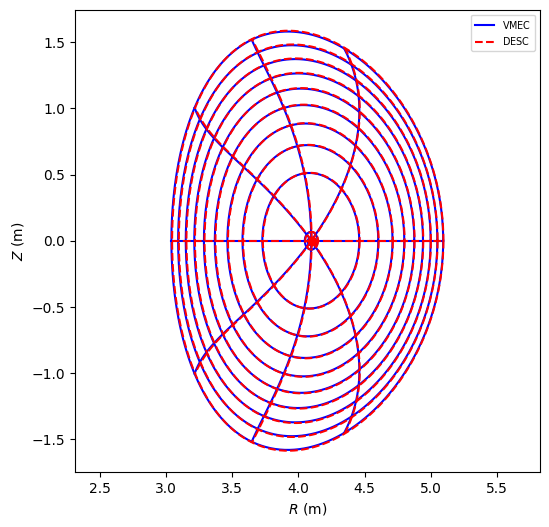

In [9]:
VMECIO.plot_vmec_comparison(eq2, "./wout_solovev_freeb.nc")

## Vacuum Stellarator

We'll again use an mgrid file for our background field:

In [10]:
extcur = [4700.0, 1000.0]
ext_field = SplineMagneticField.from_mgrid("mgrid_test.nc", extcur=extcur)

For our initial guess, we'll again use a circular torus of approximately the right major and minor radius.

In [11]:
surf = FourierRZToroidalSurface(
    R_lmn=[0.70, 0.10],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-0.10],
    modes_Z=[[-1, 0]],
    NFP=5,
)

eq_init = Equilibrium(M=6, N=6, Psi=-0.035, surface=surf)
eq_init.solve();

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 375
Number of objectives: 2450
Starting optimization
Using method: lsq-exact
`gtol` condition satisfied.
         Current function value: 1.304e-18
         Total delta_x: 2.127e-01
         Iterations: 65
         Function evaluations: 86
         Jacobian evaluations: 66
Start of solver
Total (sum of squares):  1.158e-02, 
Maximum absolute Force error:  9.655e+03 (N)
Minimum absolute Force error:  2.406e-13 (N)
Average absolute Force error:  3.130e+03 (N)
Maximum absolute Force error:  7.075e-03 (normalized)
Minimum absolute Force error:  1.763e-19 (normalized)
Average absolute Force error:  2.293e-03 (normalized)
R boundary error:  0.000e+00 (m)
Z boundary error:  0.000e+00 (m)
Fixed-Psi error:  0.000e+00 (Wb)
Fixed-pressure profile error:  0.000e+00 (Pa)
Fixed-current profile error:  0.000e+00 (A)
End of solver
Total (sum of squares):  1.304e-18, 
Maximum 

In [12]:
eq2 = eq_init.copy()

And again we'll set up our constraints.

In [13]:
constraints = (
    ForceBalance(eq=eq2),
    FixCurrent(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

The `BoundaryError` objective we just used uses the virtual casing principle to compute the plasma component of the magnetic field, required to compute the boundary error. If we know we're solving a vacuum equilibrium, we can skip this calculating since we know the plasma component of the field is zero. This is done in the `VacuumBoundaryError` objective, which is much more efficient for vacuum equilibria.

In [14]:
objective = ObjectiveFunction(VacuumBoundaryError(eq=eq2, ext_field=ext_field))

For the optimization, we'll do a "multigrid" approach where we first optimize the low order modes, and then the higher ones. For a simple problem like this it probably isn't necessary, but for higher resolution and more complicated shaping this is much more robust.

In [15]:
for k in [2, 4]:

    # get modes where |m|, |n| > k
    R_modes = (
        eq2.surface.R_basis.modes[np.max(np.abs(eq2.surface.R_basis.modes), 1) > k, :],
    )

    Z_modes = eq2.surface.Z_basis.modes[
        np.max(np.abs(eq2.surface.Z_basis.modes), 1) > k, :
    ]

    # fix those modes
    bdry_constraints = (
        FixBoundaryR(eq=eq2, modes=R_modes),
        FixBoundaryZ(eq=eq2, modes=Z_modes),
    )
    # optimize
    eq2, out = eq2.optimize(
        objective,
        constraints + bdry_constraints,
        optimizer="proximal-lsq-exact",
        verbose=3,
        options={},
    )

Building objective: Vacuum boundary error
Precomputing transforms
Timer: Precomputing transforms = 238 ms
Timer: Objective build = 986 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 212 ms
Timer: Objective build = 523 ms
Timer: Proximal projection build = 3.75 sec
Timer: Linear constraint projection build = 2.84 sec
Compiling objective function and derivatives: ['Vacuum boundary error']
Timer: Objective compilation time = 5.44 sec
Timer: Jacobian compilation time = 7.50 sec
Timer: Total compilation time = 12.9 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 2.47 sec
Timer: Jacobian compilation time = 7.01 sec
Timer: Total compilation time = 9.49 sec
Number of parameters: 25
Number of objectives: 1250
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.339e+00               

And we see that the boundary has changed quite a lot:

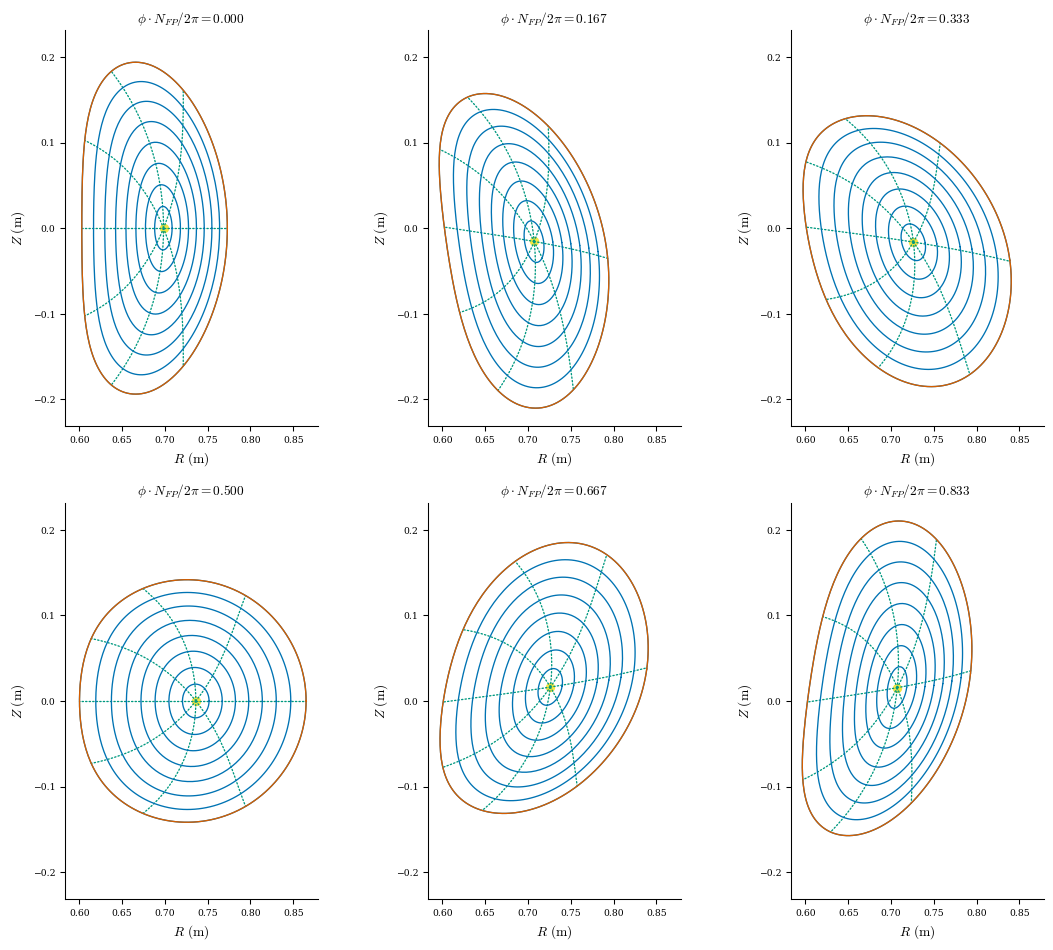

In [16]:
desc.plotting.plot_surfaces(eq2);

Because this is a vacuum equilibrium, we can verify the free boundary solution by tracing field lines directly from the external field:

In [17]:
nturns = 100  # how many turns
nplanes = 6  # how many places within 1 field period do we want output


# for starting locations we'll pick positions on flux surfaces on the outboard midplane
grid = LinearGrid(rho=np.linspace(0, 1, 9))
r0 = eq2.compute("R", grid=grid)["R"]
z0 = eq2.compute("Z", grid=grid)["Z"]
phis = (
    np.linspace(0, 2 * np.pi / eq2.NFP, nplanes, endpoint=False)
    + np.arange(0, nturns)[:, None] * 2 * np.pi / eq2.NFP
).flatten()

In [18]:
rs, zs = field_line_integrate(r0, z0, phis, ext_field)

In [19]:
zs = zs.reshape((nturns, nplanes, -1))
rs = rs.reshape((nturns, nplanes, -1))

if eq2.Psi < 0:  # field lines are traced backwards when toroidal field < 0
    rs, zs = rs[:, :: int(np.sign(eq2.Psi))], zs[:, :: int(np.sign(eq2.Psi))]
    rs, zs = np.roll(rs, 1, 1), np.roll(zs, 1, 1)

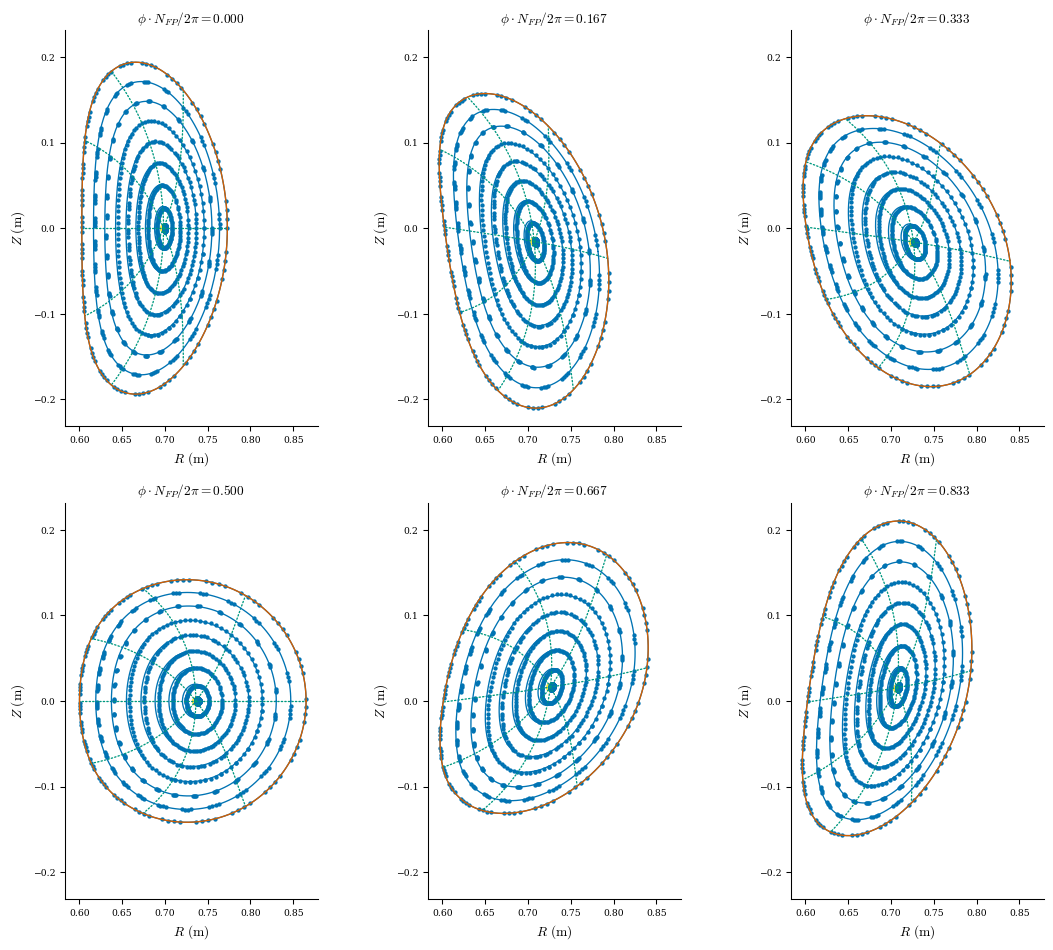

In [20]:
fig, ax = desc.plotting.plot_surfaces(eq2)
ax = ax.flatten()

for i in range(nplanes):
    ax[i].scatter(rs[:, i, :], zs[:, i, :], s=5)